In [1]:
import asyncio
import asyncpg
import pandas as pd
from datetime import datetime, timedelta
import pytz

# Establishes a connection to the PostgreSQL database using provided credentials.
async def create_db_connection():
    conn = await asyncpg.connect(
        host="localhost",
        port="your_port",
        user="your_username",
        password="your_password",
        database="your_database",
    )
    return conn

# Defines the base date for Sierra Chart timestamps.
sc_epoch = datetime(1899, 12, 30, tzinfo=pytz.UTC)

# Converts Sierra Chart timestamp (microseconds since sc_epoch) to a readable datetime object.
def convert_sc_datetime(sc_datetime_ms):
    delta = timedelta(microseconds=sc_datetime_ms)
    actual_datetime = sc_epoch + delta
    return actual_datetime

# Retrieves all rows from the database and returns them as a pandas DataFrame.
async def fetch_all_rows(conn):
    query = 'SELECT * FROM public."esm24" ORDER BY "scdatetime" DESC;'
    rows = await conn.fetch(query)
    df = pd.DataFrame(rows)
    df.columns = ['scdatetime', 'price', 'quantity', 'side'] 
    df['actual_datetime'] = df['scdatetime'].apply(convert_sc_datetime)
    df['actual_datetime'] = df['actual_datetime'].dt.tz_convert('America/Chicago')
    df.set_index('actual_datetime', inplace=True)
    df.drop(columns=['scdatetime'], inplace=True)
    df = df.sort_index()
    return df

# Main function to establish database connection and fetch data.
async def main():
    conn = await create_db_connection()
    df = await fetch_all_rows(conn)
    return df

# Initialize the asynchronous task and create the DataFrame.
df = await main()



In [2]:
# Display minimum and maximum values for the 'price' column.
print("min value: ", df['price'].min())
print("max value: ", df['price'].max())

# Display minimum and maximum values for the 'quantity' column to ensure data consistency.
print("min value of quantity: ", df['quantity'].min())
print("max value of quantity: ", df['quantity'].max())

# Verify the 'side' column only contains expected values (0 for bid, 1 for ask)
print("min value of side: ", df['side'].min())
print("max value of side: ", df['side'].max())

# Display the earliest and latest datetime entries to check the data range.
print("min value of actual_datetime: ", df.index.min())
print("max value of actual_datetime: ", df.index.max())

# Report the total number of rows to track data volume and detect any unusual changes.
print("total rows count: ", len(df))

# Check for null entries.
print("Number of null entries:\n", df.isnull().sum())

# Check the unique values in 'side'. 0 for bid, 1 for ask.
print("Unique values in 'side': ", df['side'].unique())

# Check the distribution of 'price' values.
print("Distribution of 'price' values: ", df['price'].value_counts())

min value:  4963.5
max value:  5333.5
min value of quantity:  1
max value of quantity:  2962
min value of side:  0
max value of side:  1
min value of actual_datetime:  2024-02-22 18:07:25.394000-06:00
max value of actual_datetime:  2024-05-10 15:59:59.478001-05:00
total rows count:  43818522
Number of null entries:
 price       0
quantity    0
side        0
dtype: int64
Unique values in 'side':  [1 0]
Distribution of 'price' values:  price
5211.75    95325
5212.50    95262
5211.50    93263
5212.00    90905
5212.75    90141
           ...  
4963.75      173
5330.75      126
5333.25      113
4963.50       34
5333.50        4
Name: count, Length: 1481, dtype: int64


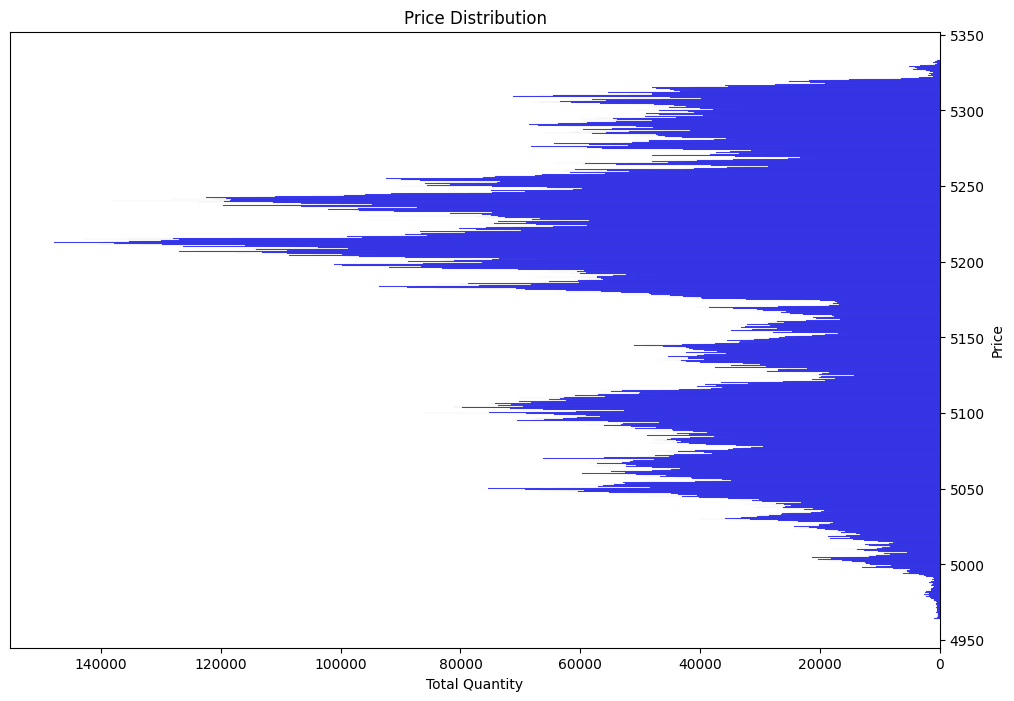

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the total quantity for each price level
df_total = df.groupby('price')['quantity'].sum().reset_index()

# Calculate the number of bins
bins = int((df_total['price'].max() - df_total['price'].min()) / 0.25)

# Create the histogram
plt.figure(figsize=(12,8))
sns.histplot(df_total, y='price', weights='quantity', bins=bins, fill=True, color='b')

# Set the title and labels
plt.title('Price Distribution')
plt.ylabel('Price')
plt.xlabel('Total Quantity')

# Invert x axis
plt.gca().invert_xaxis()

# Move y axis to the right
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")

# Show the plot
plt.show()